In [185]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [186]:
# Load features and labels
features_array = np.load('x_data.npy', allow_pickle=True)
labels_array = np.load('y_label.npy', allow_pickle=True)


In [187]:
#columns_to_remove = [
  # 'font_size', 'right_gaze_point_in_user_x', 'left_gaze_point_in_user_z', 
  # 'left_gaze_point_on_display_area_y', 'right_gaze_point_on_display_area_x', 
  # 'right_gaze_point_in_user_z', 'right_gaze_point_in_user_y', 
  # 'left_gaze_point_in_user_x', 'right_pupil_diameter', 
   #'left_gaze_origin_in_trackbox_z', 'right_gaze_origin_in_trackbox_y', 
  # 'left_gaze_origin_in_trackbox_x', 'right_gaze_origin_in_user_z', 
   #'left_gaze_origin_in_user_x', 'left_gaze_origin_in_user_y', 
   #'left_gaze_origin_validity', 'right_gaze_origin_validity', 
  # 'device_time_stamp', 'left_gaze_point_validity', 
 #  'right_gaze_point_validity', 'left_pupil_validity', 'right_pupil_validity'
#]


In [188]:
#processed_dataframes = []
#for df in features_array:
    #Drop the columns if they exist, ignore errors if some columns don't exist
  #  new_df = df.drop(columns=columns_to_remove, errors='ignore')
 #   processed_dataframes.append(new_df)

#features_array = np.array(processed_dataframes, dtype=object)

In [189]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

lengths = [df.size for df in features_array]
k = int(np.median(lengths))
# Example of handling non-numeric data before flattening
processed_features = []
encoder = OneHotEncoder(sparse=False)  # Initialize one-hot encoder

for df in features_array:
    # Check and transform non-numeric columns if necessary
    for col in df.columns:
        if df[col].dtype == object:
            # Assuming the non-numeric data is categorical and not text like 'Times New Roman'
            transformed = encoder.fit_transform(df[[col]])
            df = pd.concat([df.drop(col, axis=1), pd.DataFrame(transformed)], axis=1)
    
    # Flatten and standardize lengths as before
    flattened = df.values.flatten()
    # Use a fixed length 'k' determined as before
    if len(flattened) > k:
        processed_features.append(flattened[:k])
    else:
        processed_features.append(np.pad(flattened, (0, k - len(flattened)), 'constant'))

X = np.array(processed_features)
y = labels_array

In [190]:
print("NaNs in X:", np.isnan(X).any())
print("Infs in X:", np.isinf(X).any())

# If there are any, you might want to consider replacing them
if np.isnan(X).any() or np.isinf(X).any():
    # Replace NaNs with the mean of the column
    col_mean = np.nanmean(X, axis=0)  # Mean ignoring NaNs
    # Find indices where NaN values are
    inds = np.where(np.isnan(X))
    # Replace NaNs with the mean of each column
    X[inds] = np.take(col_mean, inds[1])

    # Replace infinities with large finite numbers
    X[np.isinf(X)] = 1e+18  # You might choose a suitable finite number

    # Re-check
    print("NaNs in X after replacement:", np.isnan(X).any())
    print("Infs in X after replacement:", np.isinf(X).any())


NaNs in X: True
Infs in X: False
NaNs in X after replacement: False
Infs in X after replacement: False


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=224182)


In [192]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
encoder = LabelEncoder()

# Fit and transform the labels to integers
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Save the encoder if you need to decode labels later
import joblib
joblib.dump(encoder, 'label_encoder.joblib')


['label_encoder.joblib']

In [193]:
# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)  # Now y_train_encoded contains integers
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)


# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [228]:
# Example reshape, adjust depending on your specific needs and data properties

X_train_reshaped = X_train.reshape(-1, 1, 89, 117)  # -1 for batch size, 1 for channel, 89x91 as an example shape
X_test_reshaped = X_test.reshape(-1, 1, 89, 117)

# Convert reshaped data to tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)

# Re-create your DataLoader with the reshaped data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


AssertionError: Size mismatch between tensors

In [229]:
print("Number of samples in X_train after trimming:", X_train_trimmed.shape[0])
print("Number of labels:", y_train_tensor.shape[0])


Number of samples in X_train after trimming: 1964
Number of labels: 982


In [226]:
# Calculate total elements and intended product from reshape dimensions
total_elements = X_train.size
intended_product = 1 * 89 * 117
num_intended_samples = total_elements / intended_product

print(f"Total elements in X_train: {total_elements}")
print(f"Expected samples after reshape: {num_intended_samples}")
print(f"Actual number of labels: {y_train_tensor.shape[0]}")


Total elements in X_train: 20451132
Expected samples after reshape: 1964.0
Actual number of labels: 982


In [223]:
import numpy as np
total_elements = X_train.size
print("Total elements in X_train:", total_elements)
# Calculate possible batches if reshaped to (1, 89, 91)
for j in range(91,100000):
    for i in range(2,100000):
        elements_per_image = i * j 
        if total_elements / elements_per_image - round(total_elements / elements_per_image) == 0:
            possible_batches = total_elements / elements_per_image
            print(i)
            print(j)
            
        


print("Possible full batches:", possible_batches)


Total elements in X_train: 20451132
2
117
4
117
89
117
178
117
356
117
491
117
982
117
1964
117
43699
117
87398
117
3
156
89
156
267
156
491
156
1473
156
43699
156
2
178
3
178
6
178
9
178
13
178
18
178
26
178
39
178
78
178
117
178
234
178
491
178
982
178
1473
178
2946
178
4419
178
6383
178
8838
178
12766
178
19149
178
38298
178
57447
178
2
234
89
234
178
234
491
234
982
234
43699
234
87398
234
2
267
3
267
4
267
6
267
12
267
13
267
26
267
39
267
52
267
78
267
156
267
491
267
982
267
1473
267
1964
267
2946
267
5892
267
6383
267
12766
267
19149
267
25532
267
38298
267
76596
267
3
356
9
356
13
356
39
356
117
356
491
356
1473
356
4419
356
6383
356
19149
356
57447
356


KeyboardInterrupt: 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(15488, 128)  # Update this to match the flattened output size
        self.fc2 = nn.Linear(128, 10)  # Assuming 10 classes

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN()
lossarr = []
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Define the training loop
def train_model(num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        lossarr.append(loss.item())

# Train the model
train_model(10)  # Adjust the number of epochs as needed


Epoch 1, Loss: 2.091935396194458
Epoch 2, Loss: 1.8006911277770996
Epoch 3, Loss: 1.3690986633300781
Epoch 4, Loss: 1.3611921072006226
Epoch 5, Loss: 1.4667400121688843
Epoch 6, Loss: 1.325818657875061
Epoch 7, Loss: 1.4907301664352417
Epoch 8, Loss: 1.2341179847717285
Epoch 9, Loss: 1.2672924995422363
Epoch 10, Loss: 1.0320713520050049


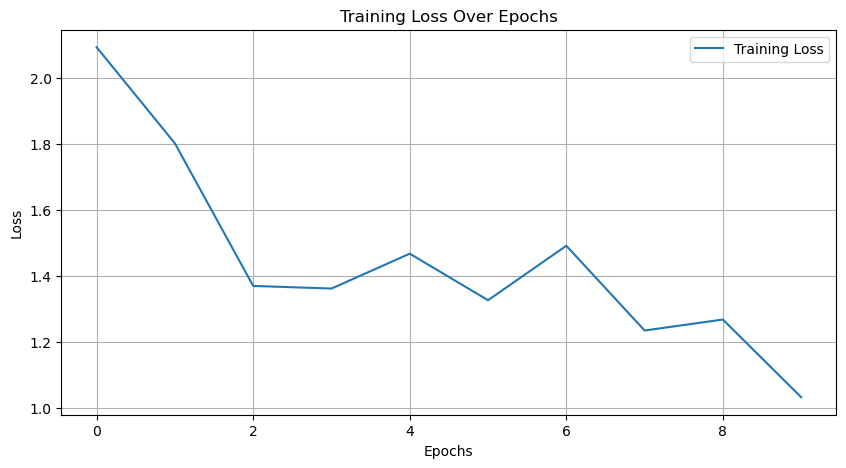

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(lossarr, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total}%')



Accuracy of the model on the test images: 41.86991869918699%


In [ ]:
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(labels_array)
label_counts

Counter({'immersive - normal': 53,
         'immersive - easy': 27,
         'immersive - hard': 34,
         'skimming - normal': 450,
         'skimming - easy': 278,
         'skimming - hard': 360,
         'immersive - really hard': 2,
         'skimming - really hard': 24})

In [ ]:
450/len(labels_array)

0.36644951140065146